Dataset: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification/code

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [27]:
import os



#the problem with this is its loading twice the first file and assuming all files have the same sample rate, so combine all sample rates to fix this next time
# Load the WAV file

# Read all WAV files in Major and Minor directories
major_files = [os.path.join("dataset/Major", f) for f in os.listdir("dataset/Major") if f.endswith('.wav')]
minor_files = [os.path.join("dataset/Minor", f) for f in os.listdir("dataset/Minor") if f.endswith('.wav')]

# Load all files
major_signals = [np.array(librosa.load(f, sr=None)[0]) for f in major_files]
minor_signals = [np.array(librosa.load(f, sr=None)[0]) for f in minor_files]

major_sample_rates= [np.array(librosa.load(f, sr=None)[1]) for f in major_files]
minor_sample_rates = [np.array(librosa.load(f, sr=None)[1]) for f in minor_files]


In [28]:
major_sample_rates
minor_sample_rates

[array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(44100),
 array(441

In [29]:
def extractF0(y):
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=major_sample_rates[0]//2, sr=major_sample_rates[0])
    f0 = f0[~np.isnan(f0)]  # Remove NaN values
    fundamental_freq = np.median(f0)  # Estimate fundamental frequency
    print(f"Estimated Fundamental Frequency (F0): {fundamental_freq:.2f} Hz")
    return fundamental_freq


In [30]:
def extractHarmonics(y, fundamental_freq):
    harmonics = [fundamental_freq * i for i in range(1, 10)]  # First 10 harmonics
    fft_spectrum = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(fft_spectrum), d=1/major_sample_rates[0])

    # Keep only the positive frequencies
    pos_mask = frequencies > 0
    fft_spectrum = np.abs(fft_spectrum[pos_mask])
    frequencies = frequencies[pos_mask]
    # Find actual harmonic peaks in the spectrum
    peaks, _ = find_peaks(fft_spectrum, height=np.max(fft_spectrum) * 0.1)  # Adjust threshold
    harmonic_freqs = frequencies[peaks]

    # Match found peaks to expected harmonic positions
    extracted_harmonics = [min(harmonic_freqs, key=lambda x: abs(x - h)) for h in harmonics]

    print("Extracted Harmonic Frequencies:", extracted_harmonics)
    return extracted_harmonics


In [31]:
# Initialize an empty list to store DataFrames
df_list = []

limit = 50   # Limit the number of signals to process
# Iterate over both major and minor signals
for chord, label in zip(major_signals[:limit] + minor_signals[:limit], ["Major"] * limit + ["Minor"] * limit):
    F0 = extractF0(chord)
    extracted_harmonics = extractHarmonics(chord,F0)
    
    # Create a dictionary with the data
    data = {
        'Label': label,
        'F0': [F0]
    }

    # Add harmonics dynamically
    for i in range(9):
        data[f'Harmonic_{i+1}'] = [extracted_harmonics[i]]
    
    # Create a DataFrame and append it to the list
    df_harmonics = pd.DataFrame(data)
    df_list.append(df_harmonics)

# Concatenate all DataFrames into a single one
combined_df = pd.concat(df_list, ignore_index=True)


Estimated Fundamental Frequency (F0): 65.60 Hz
Extracted Harmonic Frequencies: [np.float64(130.66666666666666), np.float64(130.66666666666666), np.float64(196.0), np.float64(262.22222222222223), np.float64(329.3333333333333), np.float64(392.88888888888886), np.float64(495.55555555555554), np.float64(524.8888888888889), np.float64(589.3333333333333)]
Estimated Fundamental Frequency (F0): 65.60 Hz
Extracted Harmonic Frequencies: [np.float64(165.33333333333331), np.float64(165.33333333333331), np.float64(196.44444444444443), np.float64(261.77777777777777), np.float64(329.77777777777777), np.float64(392.4444444444444), np.float64(496.0), np.float64(524.0), np.float64(589.7777777777777)]
Estimated Fundamental Frequency (F0): 120.30 Hz
Extracted Harmonic Frequencies: [np.float64(130.9090909090909), np.float64(234.0909090909091), np.float64(370.45454545454544), np.float64(468.1818181818182), np.float64(555.4545454545454), np.float64(702.7272727272727), np.float64(927.2727272727273), np.float6

In [51]:
combined_df.head(10)

,Label,F0,Harmonic_1,Harmonic_2,Harmonic_3,Harmonic_4,Harmonic_5,Harmonic_6,Harmonic_7,Harmonic_8,Harmonic_9
0,Major,65.595405,130.666667,130.666667,196.000000,262.222222,329.333333,392.888889,495.555556,524.888889,589.333333
1,Major,65.595405,165.333333,165.333333,196.444444,261.777778,329.777778,392.444444,496.000000,524.000000,589.777778
2,Major,120.302504,130.909091,234.090909,370.454545,468.181818,555.454545,702.727273,927.272727,937.727273,1113.181818
3,Major,284.481204,278.181818,556.363636,835.000000,1091.363636,1391.818182,1670.454545,1949.090909,1949.090909,1949.090909
4,Major,50.289647,155.909091,155.909091,155.909091,197.727273,278.181818,311.363636,350.454545,392.727273,466.818182
5,Major,281.213658,278.222222,556.444444,834.666667,1112.888889,1391.555556,1670.222222,1949.333333,1949.333333,1949.333333
6,Major,50.000000,156.000000,156.000000,156.000000,196.444444,272.444444,311.111111,350.222222,392.444444,466.666667
7,Major,98.282060,155.454545,195.909091,294.545455,392.272727,466.818182,589.090909,699.090909,784.545455,884.545455
8,Major,50.289647,155.909091,155.909091,155.909091,197.727273,294.090909,294.090909,350.454545,392.727273,466.818182
9,Major,276.382576,278.181818,556.363636,835.000000,1112.727273,1391.818182,1670.454545,1949.090909,1949.090909,1949.090909


In [39]:
# Separate features (X) and labels (y)
X = combined_df.drop(columns=['Label']).values  # Convert to NumPy array
y = combined_df['Label'].map({'Major': 1, 'Minor': 0}).values  # Convert labels to 0 (Minor) and 1 (Major)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features (important for training stability)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add extra dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader (batching for efficiency)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [40]:
class ChordClassifier(nn.Module):
    def __init__(self, input_size):
        super(ChordClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)  # First hidden layer
        self.fc2 = nn.Linear(32, 16)  # Second hidden layer
        self.fc3 = nn.Linear(16, 8)  # Third hidden layer
        self.output = nn.Linear(8, 1)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.output(x))  # Sigmoid activation for binary classification
        return x

# Initialise model
input_size = X_train.shape[1]  # Number of features
model = ChordClassifier(input_size)


In [48]:
# Binary Cross-Entropy loss for binary classification
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [10/200], Loss: 0.0692
Epoch [20/200], Loss: 0.0686
Epoch [30/200], Loss: 0.0684
Epoch [40/200], Loss: 0.0686
Epoch [50/200], Loss: 0.0678
Epoch [60/200], Loss: 0.0679
Epoch [70/200], Loss: 0.0676
Epoch [80/200], Loss: 0.0674
Epoch [90/200], Loss: 0.0676
Epoch [100/200], Loss: 0.0670
Epoch [110/200], Loss: 0.0669
Epoch [120/200], Loss: 0.0667
Epoch [130/200], Loss: 0.0667
Epoch [140/200], Loss: 0.0665
Epoch [150/200], Loss: 0.0666
Epoch [160/200], Loss: 0.0664
Epoch [170/200], Loss: 0.0663
Epoch [180/200], Loss: 0.0662
Epoch [190/200], Loss: 0.0662
Epoch [200/200], Loss: 0.0661
Training complete!


Neural Network Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



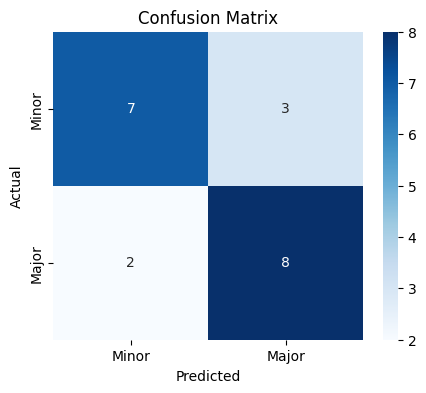

In [49]:
model.eval()
y_pred_list = []

with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        y_pred_list.append(y_pred.cpu().numpy())  # Move predictions to CPU and convert to NumPy

# Convert predictions to binary labels (threshold at 0.5)
y_pred_list = np.vstack(y_pred_list)
y_pred_binary = (y_pred_list > 0.5).astype(int).flatten()

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Neural Network Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Minor', 'Major'], yticklabels=['Minor', 'Major'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [50]:
torch.save(model.state_dict(), 'model.pth')